In [1]:
import os
import shutil
import random
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


import glob
from skimage.feature import hog # for feature extraction
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.preprocessing import image as kimage
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CNN

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
import os
from PIL import Image
import seaborn as sns
SIZE=224

In [4]:
train_images = []
train_labels = []
for directory_path in glob.glob('/content/drive/MyDrive/Atelectasis/CLAHE/train/*'):
    label = directory_path.split("/")[-1]
   # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        train_images.append(img)
        train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [5]:
# test
test_images = []
test_labels = []
for directory_path in glob.glob('/content/drive/MyDrive/Atelectasis/CLAHE/test/*'):
    fruit_label = directory_path.split("/")[-1]
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        test_images.append(img)
        test_labels.append(fruit_label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [6]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [7]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
from sklearn.model_selection import train_test_split
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [8]:
# Normalize pixel values to between 0 and 1
#x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [9]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train,2)
y_test_one_hot = to_categorical(y_test,2)

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_valid,train_label,valid_label = train_test_split(x_train, y_train_one_hot, test_size=0.1, random_state=5)

In [11]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (3600, 224, 224)
x_test shape: (1000, 224, 224)
3600 train samples
1000 test samples


In [12]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [ ]:
x_train.shape,x_valid.shape,train_label.shape,valid_label.shape

((3600, 224, 224), (400, 224, 224), (3600, 2), (400, 2))

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def InceptionModule(x, filters):
    filters1, filters3_reduce, filters3, filters5_reduce, filters5, filters_pool = filters

    # 1x1 convolution
    conv1x1 = layers.Conv2D(filters1, (1, 1), padding='same', activation='relu')(x)

    # 1x1 convolution followed by 3x3 convolution
    conv3x3_reduce = layers.Conv2D(filters3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters3, (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    # 1x1 convolution followed by 5x5 convolution
    conv5x5_reduce = layers.Conv2D(filters5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv5x5 = layers.Conv2D(filters5, (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    # 3x3 max pooling followed by 1x1 convolution
    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate the outputs along the last axis (channel axis)
    inception_module = layers.Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_proj])

    return inception_module

In [14]:
def InceptionV1(input_shape=(224, 224, 1)):
    # Define the input as a tensor with shape input_shape
    x_input = tf.keras.Input(input_shape)

    # Initial Convolution
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x_input)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # First Inception module
    x = InceptionModule(x, filters=[64, 96, 128, 16, 32, 32])

    # Second Inception module
    x = InceptionModule(x, filters=[128, 128, 192, 32, 96, 64])

    # MaxPooling layer
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Third Inception module
    x = InceptionModule(x, filters=[192, 96, 208, 16, 48, 64])

    # Fourth Inception module
    x = InceptionModule(x, filters=[160, 112, 224, 24, 64, 64])

    # Output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2, activation='sigmoid')(x)

    # Create model
    model = models.Model(inputs=x_input, outputs=x, name='InceptionV1')

    return model

# Create InceptionV1 model for binary classification
model = InceptionV1()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "InceptionV1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         3200      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_2 (Conv2D)           (None, 56, 56, 96)           6240      ['max_pooling2d[0][0

In [15]:
import datetime
start = datetime.datetime.now()
#Train the CNN model
history = model.fit(x_train, train_label, epochs=50,batch_size = 64, validation_data = (x_valid, valid_label))
end = datetime.datetime.now()

print("Total execution time is: ", end-start)

Epoch 1/50
57/57 [==============================] - 43s 320ms/step - loss: 0.6925 - accuracy: 0.5069 - val_loss: 0.6696 - val_accuracy: 0.6650
Epoch 2/50
57/57 [==============================] - 16s 281ms/step - loss: 0.6016 - accuracy: 0.6981 - val_loss: 0.4110 - val_accuracy: 0.8975
Epoch 3/50
57/57 [==============================] - 16s 283ms/step - loss: 0.2867 - accuracy: 0.8961 - val_loss: 0.2178 - val_accuracy: 0.9275
Epoch 4/50
57/57 [==============================] - 16s 285ms/step - loss: 0.1617 - accuracy: 0.9433 - val_loss: 0.1522 - val_accuracy: 0.9450
Epoch 5/50
57/57 [==============================] - 16s 283ms/step - loss: 0.0904 - accuracy: 0.9700 - val_loss: 0.1941 - val_accuracy: 0.9375
Epoch 6/50
57/57 [==============================] - 16s 281ms/step - loss: 0.1781 - accuracy: 0.9389 - val_loss: 0.0816 - val_accuracy: 0.9750
Epoch 7/50
57/57 [==============================] - 16s 282ms/step - loss: 0.0707 - accuracy: 0.9761 - val_loss: 0.0773 - val_accuracy: 0.9775

In [16]:
#test_eval = feature_extractor.evaluate(x_test, y_test_one_hot, verbose=1)
score = model.evaluate(x_test, y_test_one_hot, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

32/32 [==============================] - 4s 72ms/step - loss: 0.0748 - accuracy: 0.9880
Test loss: 0.07481447607278824
Test accuracy: 0.9879999756813049


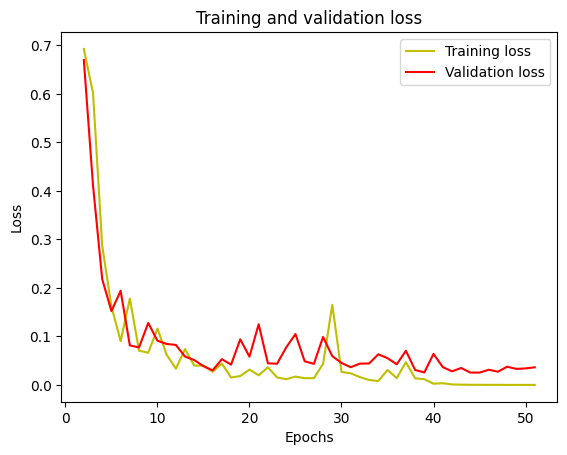

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(2, len(loss) + 2)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

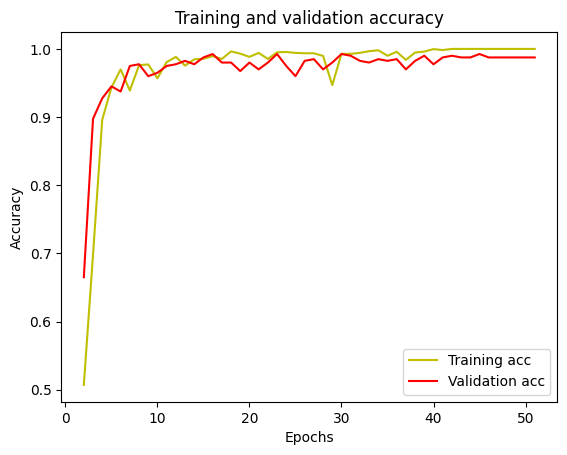

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
#test_eval = feature_extractor.evaluate(x_test, y_test_one_hot, verbose=1)
score = model.evaluate(x_train, train_label, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

113/113 [==============================] - 6s 49ms/step - loss: 7.0369e-05 - accuracy: 1.0000
Train loss: 7.036913302727044e-05
Train accuracy: 1.0


In [34]:
#Validation
score = model.evaluate(x_valid, valid_label, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

13/13 [==============================] - 1s 52ms/step - loss: 0.0364 - accuracy: 0.9875
Validation loss: 0.03639470413327217
Validation accuracy: 0.987500011920929


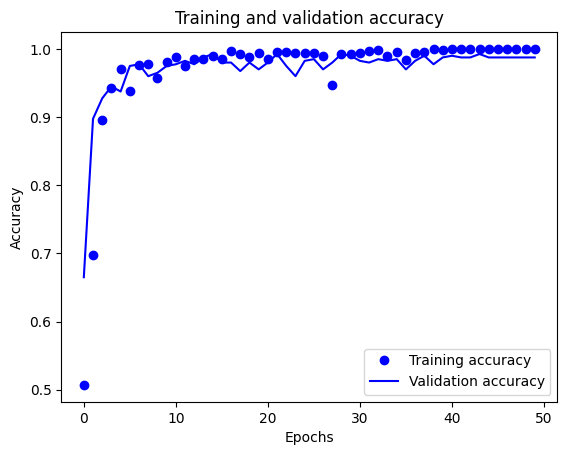

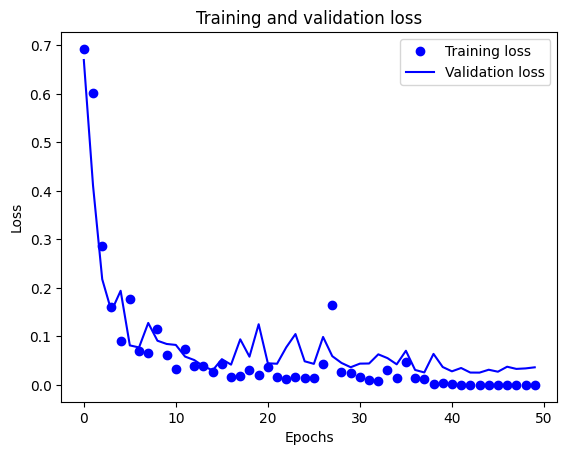

In [20]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [35]:
prediction_NN = model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=1)
prediction_NN = le.inverse_transform(prediction_NN)

32/32 [==============================] - 1s 46ms/step


[[494   6]
 [  6 494]]


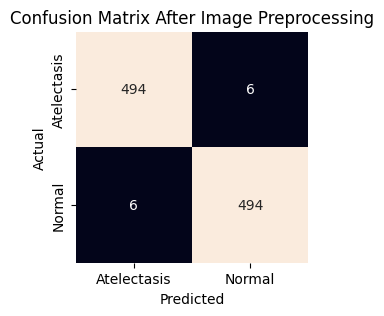

In [36]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
nClasses = ['Atelectasis','Normal']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
plt.title('Confusion Matrix After Image Preprocessing')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=nClasses, yticklabels=nClasses, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [37]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
#plt.title('Classification Report Before Image Preprocessing')
print(classification_report(test_labels, prediction_NN, target_names=['Atelectasis  (Class 0)','Normal (Class 1)']))

                        precision    recall  f1-score   support

Atelectasis  (Class 0)       0.99      0.99      0.99       500
      Normal (Class 1)       0.99      0.99      0.99       500

              accuracy                           0.99      1000
             macro avg       0.99      0.99      0.99      1000
          weighted avg       0.99      0.99      0.99      1000



In [28]:
predicted_classes = model.predict(x_test)

32/32 [==============================] - 1s 45ms/step


In [29]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, y_test.shape

((1000,), (1000,))

Found 988 correct labels


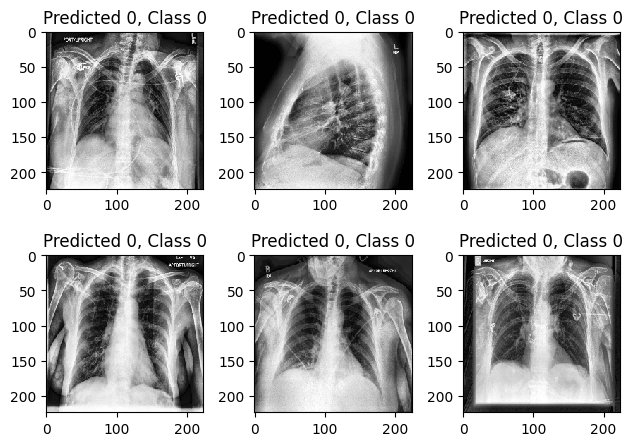

In [30]:
correct = np.where(predicted_classes==y_test)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[correct], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

Found 12 incorrect labels


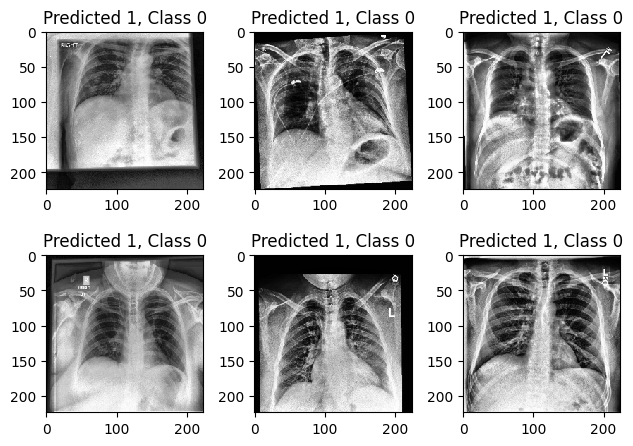

In [31]:
incorrect = np.where(predicted_classes!=y_test)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[incorrect], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

1/1 [==============================] - 1s 515ms/step
The prediction for this image is:  ['Atelectasis']
The actual label for this image is:  Atelectasis


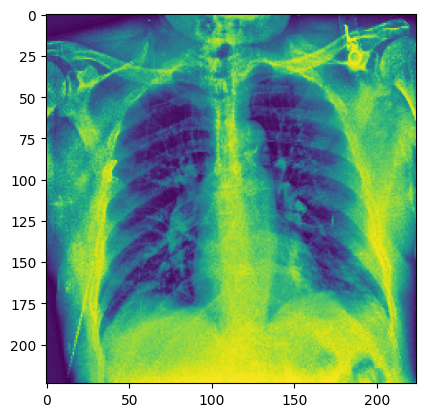

In [32]:
#Check results on a few select images
n=19  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

# Features from convolutional network for RF and SVM

In [ ]:
#Now, let us use features from convolutional network for RF
X_for_RF = model.predict(x_train) #This is out X input to RF

50/50 [==============================] - 2s 45ms/step


# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [ ]:
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [ ]:
#Send test data through same feature extractor process
X_test_feature = model.predict(x_test)
#Now predict using the trained RF model.
prediction_RF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back.
prediction_RF = le.inverse_transform(prediction_RF)

13/13 [==============================] - 1s 49ms/step


In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.975


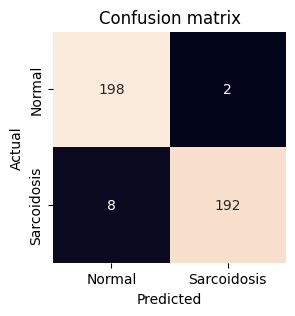

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_RF)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400



# SVM with CNN

# 1. Linear SVM

In [ ]:
from sklearn.svm import  SVC
from sklearn.svm import LinearSVC
svclassifier = SVC(kernel='linear', degree=8)
#model = LinearSVC(max_iter=100)  #Default of 100 is not converging

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', degree=8)
svclassifier.fit(X_for_RF, y_train)

SVC(degree=8, kernel='linear')

In [ ]:
X_test_feature = model.predict(x_test)
prediction_SVC = svclassifier.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)

13/13 [==============================] - 1s 47ms/step


In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.975


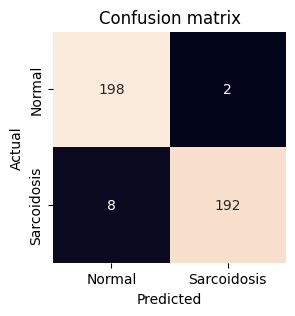

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400



# 2. Gaussian Kernel- rbf

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', degree=8)
svclassifier.fit(X_for_RF, y_train)

SVC(degree=8)

In [ ]:
prediction_SVC = svclassifier.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.975


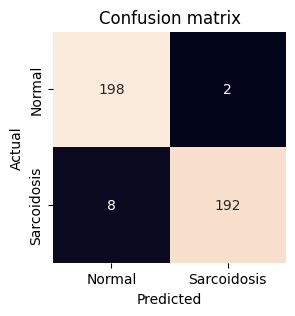

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400



# 3. Polynomial Kernel SVM

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_for_RF, y_train)

SVC(degree=8, kernel='poly')

In [ ]:
prediction_SVC = svclassifier.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.975


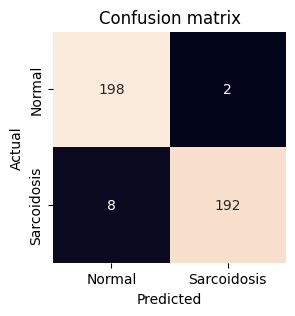

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400



# 4. Sigmoid

In [ ]:
from sklearn.svm import SVC
svcmodel = SVC(kernel='sigmoid', degree=8)
svcmodel.fit(X_for_RF, y_train)

SVC(degree=8, kernel='sigmoid')

In [ ]:
prediction_SVC = svcmodel.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.9725


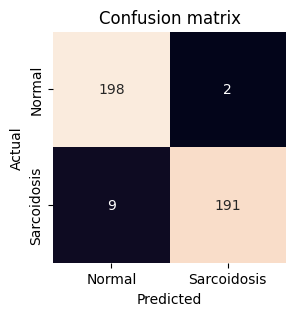

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400

